# Практика застосування лінійної регресії

In [4]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from scipy.stats import zscore

### Завантажуємо набір даних

In [14]:
california_housing = fetch_california_housing(as_frame=True)
california_housing.data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


### Видаляємо викиди

In [16]:
features_of_interest = ['AveRooms', 'AveBedrms', 'AveOccup', 'Population']

z_scores = california_housing.data[features_of_interest].apply(zscore)

filtered_data = california_housing.data[(z_scores.abs() <= 3).all(axis=1)]

### Будуємо матрицю кореляції і видаляємо ознаку з високою кореляцією

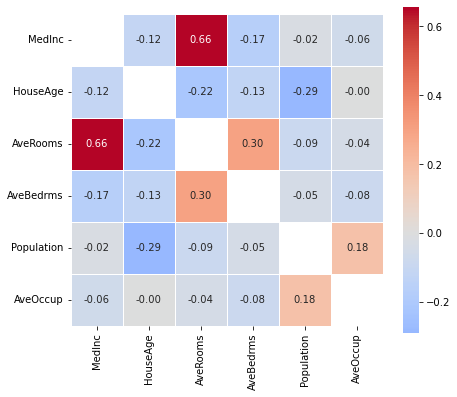

In [7]:
columns_drop = ['Longitude', 'Latitude']
subset = filtered_data.drop(columns=columns_drop)

corr_mtx = subset.corr()

mask_mtx = np.zeros_like(corr_mtx)
np.fill_diagonal(mask_mtx, 1)

fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(subset.corr(),
            cmap='coolwarm',
            center=0,
            annot=True,
            fmt='.2f',
            linewidth=0.5,
            square=True,
            mask=mask_mtx,
            ax=ax)

plt.show()

# Видаляємо AveRooms із-за високої кореляції
filtered_data = filtered_data.drop(columns=['AveRooms'])

### Розбиваємо на навчальну і тестову вибірки

In [8]:
filtered_target = california_housing.target[filtered_data.index]

X_train, X_test, y_train, y_test = train_test_split(
    filtered_data,
    filtered_target,
    test_size=0.2,
    random_state=42
)

### Нормалізуємо ознаки

In [17]:
scaler = StandardScaler().set_output(transform='pandas').fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.describe()

,MedInc,HouseAge,AveBedrms,Population,AveOccup,Latitude,Longitude
count,1.610800e+04,1.610800e+04,1.610800e+04,1.610800e+04,1.610800e+04,1.610800e+04,1.610800e+04
mean,-1.676224e-17,-1.248346e-16,1.764447e-17,-1.060874e-16,-3.793561e-17,-1.722100e-15,-8.151744e-16
std,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00
min,-1.773858e+00,-2.240869e+00,-5.444216e+00,-1.644220e+00,-2.448193e+00,-1.450260e+00,-2.367900e+00
25%,-6.876112e-01,-7.974045e-01,-4.671025e-01,-6.811515e-01,-5.624555e-01,-7.992891e-01,-1.106958e+00
50%,-1.764550e-01,4.520411e-03,-1.525954e-01,-2.266418e-01,-1.286644e-01,-6.447421e-01,5.377489e-01
75%,4.568290e-01,6.460603e-01,2.172224e-01,4.354681e-01,3.899295e-01,9.709764e-01,7.869470e-01
max,5.862520e+00,1.848948e+00,1.070880e+01,4.271775e+00,3.487352e+01,2.951988e+00,2.511397e+00


### Будуємо модель

In [10]:
model = LinearRegression().fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

ymin, ymax = y_train.agg(['min', 'max']).values

y_pred = pd.Series(y_pred, index=X_test_scaled.index).clip(ymin, ymax)
y_pred.head()

7969     2.415358
17082    2.745517
5623     1.710072
16934    2.593909
7501     1.638296
dtype: float64

### Оцінюємо показники моделі

In [12]:
r_sq = model.score(X_train_scaled, y_train)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'R2: {r_sq:.2f} | MAE: {mae:.2f} | MAPE: {mape:.2f}')

R2: 0.64 | MAE: 0.50 | MAPE: 0.29


In [18]:
pd.Series(model.coef_, index=X_train_scaled.columns)

MedInc        0.716183
HouseAge      0.135899
AveBedrms     0.091373
Population    0.043995
AveOccup     -0.232099
Latitude     -1.022909
Longitude    -0.949422
dtype: float64

### Будуємо поліноміальну регресію, щоб покращити результат

In [19]:
# [a, b] -> [1, a, b, a^2, ab, b^2]
poly = PolynomialFeatures(2).set_output(transform='pandas')

Xtr = poly.fit_transform(X_train_scaled)
Xts = poly.transform(X_test_scaled)

model_upd = LinearRegression().fit(Xtr, y_train)
y_pred_upd = model_upd.predict(Xts)
y_pred_upd = pd.Series(y_pred_upd, index=Xts.index).clip(ymin, ymax)

r_sq_upd = model_upd.score(Xtr, y_train)
mae_upd = mean_absolute_error(y_test, y_pred_upd)
mape_upd = mean_absolute_percentage_error(y_test, y_pred_upd)

print(f'R2: {r_sq_upd:.2f} | MAE: {mae_upd:.2f} | MAPE: {mape_upd:.2f}')

R2: 0.69 | MAE: 0.46 | MAPE: 0.26


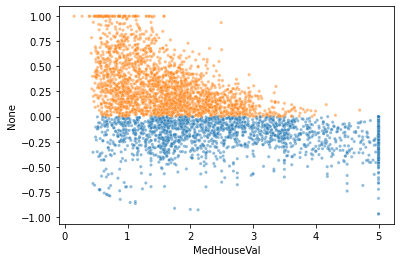

In [20]:

pct_error = (y_pred_upd / y_test - 1).clip(-1, 1)

sns.scatterplot(
    x=y_test,
    y=pct_error,
    hue=pct_error.gt(0),
    alpha=0.5,
    s=10,
    legend=False)

plt.show()

## Висновки

### R2 (коефіцієнт детермінації):

Попередній результат: 0.60
Лінійна регресія: 0.64
Поліноміальна регресія: 0.69
Очікуваний результат: 0.70

Поліноміальна регресія показала значно кращий результат, ніж лінійна регресія і попередні результати, що свідчить про значне поліпшення моделі.

### MAE (середня абсолютна похибка):

Попередній результат: 0.54
Лінійна регресія: 0.50
Поліноміальна регресія: 0.46
Очікуваний результат: 0.45

MAE для поліноміальної регресії становить 0.46, що є значним поліпшенням порівняно з лінійною регресією і попередніми результатами.

### MAPE (середня абсолютна похибка):

Попередній результат: 0.28
Лінійна регресія: 0.29
Поліноміальна регресія: 0.26
Очікуваний результат: 0.25

MAPE для поліноміальної регресії становить 0.26, що є поліпшенням порівняно з лінійною регресією і попередніми результатами. Хоча це значення не досягає очікуваного рівня, воно показує позитивний тренд у напрямку поліпшення.

### Загальні висновки:

Поліноміальна регресія показала кращі результати за всіма основними метриками порівняно з лінійною регресією і попередніми результатами. Вона значно покращила показник R2 і знизила MAE та MAPE.